# Data Science in Transportation
## Demo with `python` `pandas` and NYC citi bikes data
In this demo you will:
* download the online data
* parse it to `pandas DataFrame`


# Prerequisites
Before you start make sure you have installed:
* [python](https://www.python.org/downloads/) (tested for 3.6.3 version)
* python IDE (personally I reccommend [pyCharm](https://www.jetbrains.com/pycharm/))
* pip integrated with shell, so that `pip install pandas` will work

# Data source
We use freely available datasets provided by _citi bike_ available [here](https://www.citibikenyc.com/system-data)
in this tutorial we focus on the historical data sets provided in this [amazon bucket](https://s3.amazonaws.com/tripdata/index.html)
for stability I copied three selected months data in the repo folder



In [ ]:
%matplotlib inline
from sandbox.citi.analyzer import *
from sandbox.citi.readers import *
from sandbox.citi.day_clusterer import *
from sandbox.citi.stations import *
from sandbox.citi.matrices import *
import warnings
warnings.filterwarnings('ignore')

## Read csv data of 3 months

Reading 291MB file of 1,557,663 trips recorded on 201608


Reading 271MB file of 1,460,318 trips recorded on 201606


Reading 308MB file of 1,648,856 trips recorded on 201609


Reading 257MB file of 1,380,110 trips recorded on 201607


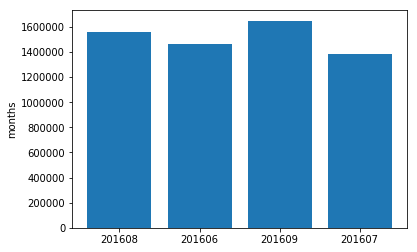

Storing data into hd5 file of 799MB


True

In [4]:
dfs = read()  # main trips reader
dump_dfs(dfs, ["trips"], _path=read_json_config()['HDFSTORE_PATH_JUPYTER'])  # dump the data


## Read the real time GBFS data

In [5]:
dfs = update_CITI_RT(dfs)  # real time json data
dump_dfs(dfs, list(read_json_config()['CITI_RT'].keys()), _path=read_json_config()['HDFSTORE_PATH_JUPYTER'])

Reading real time GBFS feed of 0 rows from system_alerts.json


Reading real time GBFS feed of 12 rows from system_information.json


Reading real time GBFS feed of 816 rows from station_information.json


Reading real time GBFS feed of 816 rows from station_status.json


Reading real time GBFS feed of 3 rows from system_regions.json
Storing data into hd5 file of 776.0199279785156MB


True

Describe the trips readed

In [10]:
dfs['trips'].describe()

,tripduration,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid,birth year,gender
count,6.046947e+06,6.046947e+06,6.046947e+06,6.046947e+06,6.046947e+06,6.046947e+06,6.046947e+06,6.046947e+06,5.218007e+06,6.046947e+06
mean,9.781649e+02,1.080241e+03,4.073765e+01,-7.398639e+01,1.067150e+03,4.073721e+01,-7.398633e+01,2.126056e+04,1.978180e+03,1.079281e+00
std,9.403942e+03,1.192638e+03,2.445683e-02,1.667313e-02,1.184672e+03,7.061681e-02,1.215055e-01,3.664738e+03,1.156683e+01,5.932939e-01
min,6.100000e+01,7.200000e+01,4.044535e+01,-7.402545e+01,7.200000e+01,0.000000e+00,-7.408364e+01,1.452900e+04,1.885000e+03,0.000000e+00
25%,4.040000e+02,3.360000e+02,4.072037e+01,-7.399810e+01,3.350000e+02,4.072020e+01,-7.399884e+01,1.803800e+04,1.970000e+03,1.000000e+00
50%,6.770000e+02,4.620000e+02,4.073902e+01,-7.398856e+01,4.610000e+02,4.073818e+01,-7.398860e+01,2.158800e+04,1.981000e+03,1.000000e+00
75%,1.150000e+03,2.006000e+03,4.075510e+01,-7.397711e+01,2.004000e+03,4.075467e+01,-7.397722e+01,2.489500e+04,1.987000e+03,1.000000e+00
max,6.707533e+06,3.436000e+03,4.080421e+01,-7.392850e+01,3.436000e+03,4.080421e+01,0.000000e+00,2.731600e+04,2.000000e+03,2.000000e+00


## Process the data

In [7]:
config_plotly
dfs = read_from_hdf()
dfs['stations'] = make_station_df(dfs)

import plotly.plotly as py
from plotly.graph_objs import *
topsize = 30

data = [Scattermapbox(
            lat=dfs.stations.lat, lon=dfs.stations.lon,       
            mode='markers',
            marker=Marker(
                size=dfs.stations.capacity / 300 * dfs.stations.capacity.max(),
                opacity=0.7
            ),
            text="Station: "+str(dfs.stations.index),
            hoverinfo='text'
        )]
    
layout = Layout(
    title='Stations of the system with their capacities',
    autosize=True,
    hovermode='closest',
    showlegend=False,
    mapbox=dict(
            accesstoken=read_json_config()['TOKENS']["MAPBOX"],
            bearing=0,
            center=dict(
                lat=40.73,
                lon=-73.93
            ),
            pitch=0,
            zoom=10,
            style='light'
        ),
    )
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='CITI stations')

<iframe id="igraph" scrolling="no" style="border:none;" seamless="seamless" src="https://plot.ly/~northgravity/98.embed" height="525px" width="100%"></iframe>

In [2]:
dfs = read_from_hdf()
days = describe_trip_groups(dfs['trips'])  # aggregated day description
days.describe()

AttributeError: 'DataFrame' object has no attribute 'decribe'

In [9]:


dfs['days'] = cluster_spectral(days, 8)[0]  # create clusters
dfs['trips'] = assign_trips_to_clusters(dfs)
dfs['day_clusters'] = describe_trip_groups(dfs['trips'], groups="clusters")
stations_rent_drops = drops_rentals_timeserie(trips, date_from='2016-08-06')

dfs['station_statuses'] = report_station_loads(stations_rent_drops,
                                                    initial_loads=dfs.station_status.num_bikes_available,
                                                    capacities=dfs.station_information.capacity)

dfs['tt_matrix'] = make_tt_matrix(dfs)
dfs['od_matrix'] = splitting_rates(dfs)

Estimated number of clusters: 8
Silhouette Coefficient: -0.107


AssertionError: group ``/`` does not have a child node named ``days``